In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/tomato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 551M/551M [00:26<00:00, 21.7MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/train",
    label_mode="categorical",
    class_names= ['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/valid",
    label_mode="categorical",
    class_names= ['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 17195 files belonging to 9 classes.
==========================Validation Data====================
Found 4197 files belonging to 9 classes.


In [6]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("tomato/Tomato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("tomato/Tomato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 17195 images belonging to 9 classes.
Found 4197 images belonging to 9 classes.


In [ ]:
# Check GPU
!nvidia-smi

Tue Jun  6 10:43:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

MobileNetV2 Model 1

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                           

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.8038
Epoch 1: val_accuracy improved from -inf to 0.15797, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 317s 323ms/step - loss: 0.6903 - accuracy: 0.8038 - val_loss: 7.1706 - val_accuracy: 0.1580 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8936
Epoch 2: val_accuracy improved from 0.15797 to 0.17751, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 274s 318ms/step - loss: 0.3255 - accuracy: 0.8936 - val_loss: 4.6632 - val_accuracy: 0.1775 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9215
Epoch 3: val_accuracy improved from 0.17751 to 0.48821, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 273s 318ms/step - loss: 0.2405 - accuracy: 0.9215 - val_loss: 2.6963 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9246
Epoch 4: val_accuracy did not improve from 0.48821
860/860 [==============================] - 250s 291ms/step - loss: 0.2335 - accuracy: 0.9246 - val_loss: 3.3462 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9226
Epoch 5: val_accuracy improved from 0.48821 to 0.52609, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 275s 319ms/step - loss: 0.2449 - accuracy: 0.9226 - val_loss: 2.0806 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9272
Epoch 6: val_accuracy did not improve from 0.52609
860/860 [==============================] - 251s 292ms/step - loss: 0.2290 - accuracy: 0.9272 - val_loss: 4.8979 - val_accuracy: 0.2790 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9318
Epoch 7: val_accuracy did not improve from 0.52609
860/860 [==============================] - 252s 293ms/step - loss: 0.2154 - accuracy: 0.9318 - val_loss: 4.1344 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9315
Epoch 8: val_accuracy improved from 0.52609 to 0.78985, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 274s 319ms/step - loss: 0.2136 - accuracy: 0.9315 - val_loss: 0.8277 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9395
Epoch 9: val_accuracy did not improve from 0.78985
860/860 [==============================] - 260s 302ms/step - loss: 0.1871 - accuracy: 0.9395 - val_loss: 1.8546 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 10/100
860/860 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9397
Epoch 10: val_accuracy did not improve from 0.78985
860/860 [==============================] - 252s 292ms/step - loss: 0.1836 - accuracy: 0.9397 - val_loss: 1.1000 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 11/100
860/860 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9424
Epoch 11: val_accuracy did not improve from 0.78985
860/860 [==============================] - 250s 290ms/step - loss: 0.1797 - accuracy: 0.9424 - val_loss: 0.7

860/860 [==============================] - 273s 318ms/step - loss: 0.1620 - accuracy: 0.9494 - val_loss: 0.4164 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 14/100
860/860 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9520
Epoch 14: val_accuracy improved from 0.88849 to 0.90922, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 273s 317ms/step - loss: 0.1503 - accuracy: 0.9520 - val_loss: 0.3410 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9492
Epoch 15: val_accuracy did not improve from 0.90922
860/860 [==============================] - 261s 304ms/step - loss: 0.1571 - accuracy: 0.9492 - val_loss: 1.6251 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9539
Epoch 16: val_accuracy did not improve from 0.90922
860/860 [==============================] - 252s 293ms/step - loss: 0.1459 - accuracy: 0.9539 - val_loss: 0.8513 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9515
Epoch 17: val_accuracy improved from 0.90922 to 0.91708, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 274s 318ms/step - loss: 0.1468 - accuracy: 0.9515 - val_loss: 0.2734 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9539
Epoch 18: val_accuracy did not improve from 0.91708
860/860 [==============================] - 251s 292ms/step - loss: 0.1409 - accuracy: 0.9539 - val_loss: 1.2579 - val_accuracy: 0.6964 - lr: 0.0010
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9573
Epoch 19: val_accuracy did not improve from 0.91708
860/860 [==============================] - 249s 290ms/step - loss: 0.1281 - accuracy: 0.9573 - val_loss: 0.7905 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9596
Epoch 20: val_accuracy did not improve from 0.91708
860/860 [==============================] - 252s 292ms/step - loss: 0.1281 - accuracy: 0.9596 - val_loss: 0

860/860 [==============================] - 276s 320ms/step - loss: 0.0795 - accuracy: 0.9725 - val_loss: 0.0581 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 24/100
860/860 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9773
Epoch 24: val_accuracy improved from 0.98165 to 0.98404, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 275s 319ms/step - loss: 0.0629 - accuracy: 0.9773 - val_loss: 0.0469 - val_accuracy: 0.9840 - lr: 1.0000e-04
Epoch 25/100
860/860 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9788
Epoch 25: val_accuracy did not improve from 0.98404
860/860 [==============================] - 251s 292ms/step - loss: 0.0598 - accuracy: 0.9788 - val_loss: 0.0505 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 26/100
860/860 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9810
Epoch 26: val_accuracy improved from 0.98404 to 0.98666, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 277s 322ms/step - loss: 0.0553 - accuracy: 0.9810 - val_loss: 0.0438 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 27/100
860/860 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9819
Epoch 27: val_accuracy did not improve from 0.98666
860/860 [==============================] - 251s 292ms/step - loss: 0.0503 - accuracy: 0.9819 - val_loss: 0.0412 - val_accuracy: 0.9864 - lr: 1.0000e-04
Epoch 28/100
860/860 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9817
Epoch 28: val_accuracy did not improve from 0.98666
860/860 [==============================] - 251s 292ms/step - loss: 0.0508 - accuracy: 0.9817 - val_loss: 0.0432 - val_accuracy: 0.9862 - lr: 1.0000e-04
Epoch 29/100
860/860 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9819
Epoch 29: val_accuracy improved from 0.98666 to 0.98904, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 278s 323ms/step - loss: 0.0497 - accuracy: 0.9819 - val_loss: 0.0370 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 30/100
860/860 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9823
Epoch 30: val_accuracy improved from 0.98904 to 0.98952, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 276s 321ms/step - loss: 0.0483 - accuracy: 0.9823 - val_loss: 0.0325 - val_accuracy: 0.9895 - lr: 1.0000e-04
Epoch 31/100
860/860 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9833
Epoch 31: val_accuracy did not improve from 0.98952
860/860 [==============================] - 264s 307ms/step - loss: 0.0459 - accuracy: 0.9833 - val_loss: 0.0488 - val_accuracy: 0.9852 - lr: 1.0000e-04
Epoch 32/100
860/860 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9825
Epoch 32: val_accuracy did not improve from 0.98952
860/860 [==============================] - 263s 305ms/step - loss: 0.0476 - accuracy: 0.9825 - val_loss: 0.0478 - val_accuracy: 0.9836 - lr: 1.0000e-04
Epoch 33/100
860/860 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9835
Epoch 33: val_accuracy improved from 0.98952 to 0.98999, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 278s 323ms/step - loss: 0.0445 - accuracy: 0.9835 - val_loss: 0.0312 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 34/100
860/860 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9827
Epoch 34: val_accuracy did not improve from 0.98999
860/860 [==============================] - 255s 297ms/step - loss: 0.0452 - accuracy: 0.9827 - val_loss: 0.0307 - val_accuracy: 0.9895 - lr: 1.0000e-04
Epoch 35/100
860/860 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9845
Epoch 35: val_accuracy did not improve from 0.98999
860/860 [==============================] - 255s 296ms/step - loss: 0.0422 - accuracy: 0.9845 - val_loss: 0.0405 - val_accuracy: 0.9869 - lr: 1.0000e-04
Epoch 36/100
860/860 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9849
Epoch 36: val_accuracy did not improve from 0.98999
860/860 [==============================] - 254s 295ms/step - loss: 0.0418 - accuracy: 0.9849 -

860/860 [==============================] - 277s 323ms/step - loss: 0.0372 - accuracy: 0.9862 - val_loss: 0.0330 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 41/100
860/860 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9873
Epoch 41: val_accuracy did not improve from 0.99047
860/860 [==============================] - 255s 296ms/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.0339 - val_accuracy: 0.9900 - lr: 1.0000e-05
Epoch 42/100
860/860 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9881
Epoch 42: val_accuracy did not improve from 0.99047
860/860 [==============================] - 255s 296ms/step - loss: 0.0328 - accuracy: 0.9881 - val_loss: 0.0329 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 43/100
860/860 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9874
Epoch 43: val_accuracy improved from 0.99047 to 0.99071, saving model to Tomato_MobileNetV2_model1_Based_Augmented


860/860 [==============================] - 279s 325ms/step - loss: 0.0345 - accuracy: 0.9874 - val_loss: 0.0327 - val_accuracy: 0.9907 - lr: 1.0000e-05
Epoch 44/100
860/860 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9876
Epoch 44: val_accuracy improved from 0.99071 to 0.99118, saving model to Tomato_MobileNetV2_model1_Based_Augmented



Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
860/860 [==============================] - 279s 324ms/step - loss: 0.0342 - accuracy: 0.9876 - val_loss: 0.0327 - val_accuracy: 0.9912 - lr: 1.0000e-05
Epoch 45/100
860/860 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9870
Epoch 45: val_accuracy did not improve from 0.99118
860/860 [==============================] - 256s 298ms/step - loss: 0.0333 - accuracy: 0.9870 - val_loss: 0.0327 - val_accuracy: 0.9912 - lr: 1.0000e-06
Epoch 46/100
860/860 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9876
Epoch 46: val_accuracy did not improve from 0.99118
860/860 [==============================] - 256s 298ms/step - loss: 0.0335 - accuracy: 0.9876 - val_loss: 0.0326 - val_accuracy: 0.9912 - lr: 1.0000e-06
Epoch 47/100
860/860 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9867
Epoch 47: val_accuracy did not improve from 0.99118
860/860 [======

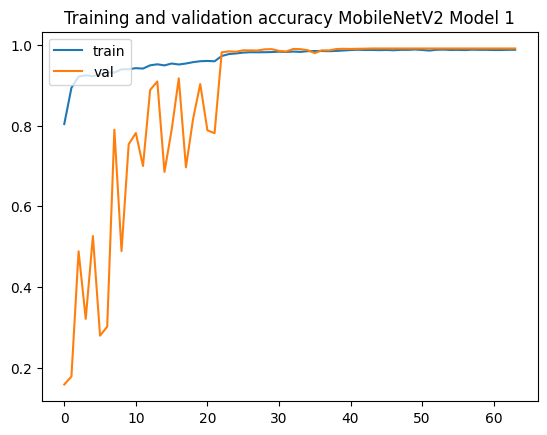

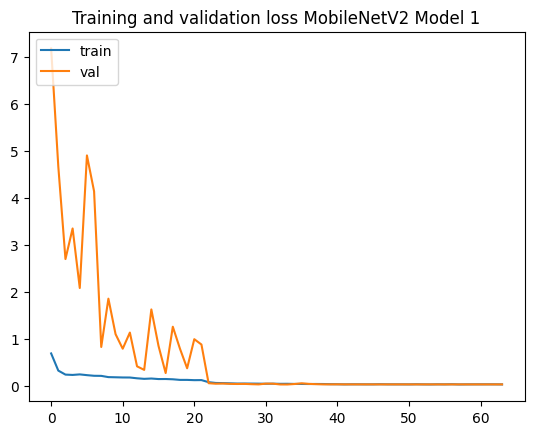

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
!zip -r /content/Tomato_MobileNetV2_model1_Based_Augmented.zip /content/Tomato_MobileNetV2_model1_Based_Augmented

  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/variables/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/variables/variables.index (deflated 77%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/assets/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Augmented/saved_model.pb (deflated 91%)


MobileNetV2 Model 2

In [7]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [8]:
# Define DIY Model
MobileNetV2_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
MobileNetV2_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                           

In [9]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.8356
Epoch 1: val_accuracy improved from -inf to 0.23255, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 340s 348ms/step - loss: 0.5140 - accuracy: 0.8356 - val_loss: 13.5603 - val_accuracy: 0.2325 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.9100
Epoch 2: val_accuracy did not improve from 0.23255
860/860 [==============================] - 267s 310ms/step - loss: 0.2843 - accuracy: 0.9100 - val_loss: 15.1644 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9188
Epoch 3: val_accuracy improved from 0.23255 to 0.66166, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 287s 334ms/step - loss: 0.2546 - accuracy: 0.9188 - val_loss: 1.5326 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9291
Epoch 4: val_accuracy improved from 0.66166 to 0.79652, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 289s 336ms/step - loss: 0.2208 - accuracy: 0.9291 - val_loss: 0.7725 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9363
Epoch 5: val_accuracy did not improve from 0.79652
860/860 [==============================] - 265s 308ms/step - loss: 0.1973 - accuracy: 0.9363 - val_loss: 4.1137 - val_accuracy: 0.4894 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9382
Epoch 6: val_accuracy did not improve from 0.79652
860/860 [==============================] - 264s 307ms/step - loss: 0.1897 - accuracy: 0.9382 - val_loss: 2.2901 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.9418
Epoch 7: val_accuracy did not improve from 0.79652
860/860 [==============================] - 266s 309ms/step - loss: 0.1776 - accuracy: 0.9418 - val_loss: 4.3331 

860/860 [==============================] - 291s 338ms/step - loss: 0.0961 - accuracy: 0.9666 - val_loss: 0.0461 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 11/100
860/860 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9740
Epoch 11: val_accuracy did not improve from 0.98570
860/860 [==============================] - 268s 312ms/step - loss: 0.0731 - accuracy: 0.9740 - val_loss: 0.0535 - val_accuracy: 0.9824 - lr: 1.0000e-04
Epoch 12/100
860/860 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9750
Epoch 12: val_accuracy did not improve from 0.98570
860/860 [==============================] - 274s 318ms/step - loss: 0.0696 - accuracy: 0.9750 - val_loss: 0.0856 - val_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 13/100
860/860 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9763
Epoch 13: val_accuracy did not improve from 0.98570
860/860 [==============================] - 264s 307ms/step - loss: 0.0658 - accuracy: 0.9763 -

860/860 [==============================] - 287s 334ms/step - loss: 0.0587 - accuracy: 0.9782 - val_loss: 0.0399 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9787
Epoch 15: val_accuracy did not improve from 0.98737
860/860 [==============================] - 265s 309ms/step - loss: 0.0576 - accuracy: 0.9787 - val_loss: 0.0608 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9802
Epoch 16: val_accuracy did not improve from 0.98737
860/860 [==============================] - 265s 308ms/step - loss: 0.0548 - accuracy: 0.9802 - val_loss: 0.0501 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9809
Epoch 17: val_accuracy improved from 0.98737 to 0.98904, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 287s 334ms/step - loss: 0.0510 - accuracy: 0.9809 - val_loss: 0.0397 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9809
Epoch 18: val_accuracy improved from 0.98904 to 0.98975, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 287s 334ms/step - loss: 0.0517 - accuracy: 0.9809 - val_loss: 0.0377 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9826
Epoch 19: val_accuracy did not improve from 0.98975
860/860 [==============================] - 271s 315ms/step - loss: 0.0490 - accuracy: 0.9826 - val_loss: 0.0447 - val_accuracy: 0.9852 - lr: 1.0000e-04
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9827
Epoch 20: val_accuracy improved from 0.98975 to 0.99071, saving model to Tomato_MobileNetV2_model2_Based_Augmented


860/860 [==============================] - 290s 338ms/step - loss: 0.0460 - accuracy: 0.9827 - val_loss: 0.0336 - val_accuracy: 0.9907 - lr: 1.0000e-04
Epoch 21/100
860/860 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9828
Epoch 21: val_accuracy did not improve from 0.99071
860/860 [==============================] - 269s 312ms/step - loss: 0.0471 - accuracy: 0.9828 - val_loss: 0.0658 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 22/100
860/860 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9845
Epoch 22: val_accuracy did not improve from 0.99071
860/860 [==============================] - 276s 320ms/step - loss: 0.0429 - accuracy: 0.9845 - val_loss: 0.0461 - val_accuracy: 0.9862 - lr: 1.0000e-04
Epoch 23/100
860/860 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9839
Epoch 23: val_accuracy did not improve from 0.99071
860/860 [==============================] - 265s 308ms/step - loss: 0.0410 - accuracy: 0.9839 -

860/860 [==============================] - 295s 343ms/step - loss: 0.0442 - accuracy: 0.9835 - val_loss: 0.0310 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 25/100
860/860 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9855
Epoch 25: val_accuracy did not improve from 0.99095
860/860 [==============================] - 265s 308ms/step - loss: 0.0400 - accuracy: 0.9855 - val_loss: 0.0407 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 26/100
860/860 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9860
Epoch 26: val_accuracy did not improve from 0.99095
860/860 [==============================] - 273s 317ms/step - loss: 0.0374 - accuracy: 0.9860 - val_loss: 0.0422 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 27/100
860/860 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9861
Epoch 27: val_accuracy did not improve from 0.99095
860/860 [==============================] - 263s 305ms/step - loss: 0.0402 - accuracy: 0.9861 -

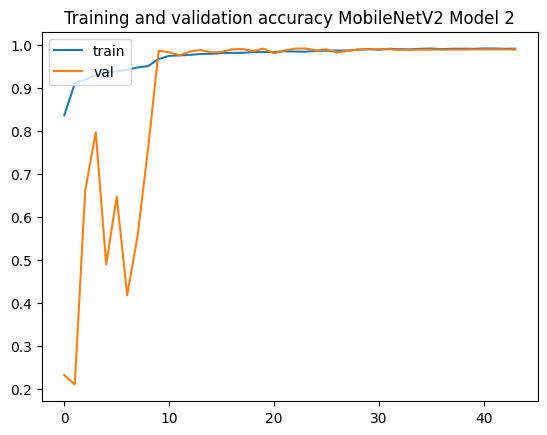

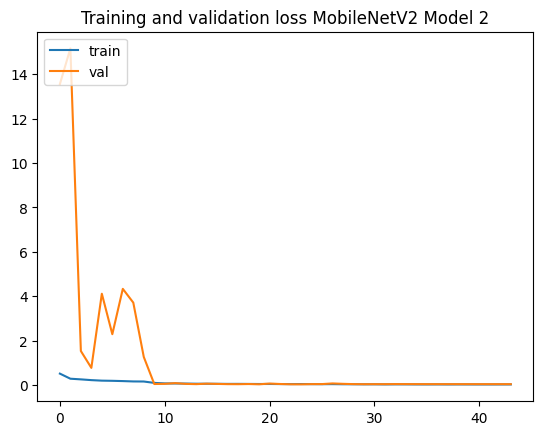

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [11]:
!zip -r /content/Tomato_MobileNetV2_model2_Based_Augmented.zip /content/Tomato_MobileNetV2_model2_Based_Augmented

  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/variables/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/variables/variables.index (deflated 77%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/assets/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Augmented/saved_model.pb (deflated 91%)
